# **Analyzing Tweets and Predicting Suicide Intention Rate**

Abigail Dawn Davocol, Karmela Castro, and Joever Eduard Facultad 




## **1. Import Packages**

In [ ]:
import re
import sys
import nltk
import collections
import textblob   
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from textblob import Word 
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from matplotlib import style
style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **2. Import Dataset**

In [ ]:
### Load the data
url = 'https://github.com/laxmimerit/twitter-suicidal-intention-dataset/blob/master/twitter-suicidal_data.csv?raw=true'
df = pd.read_csv(url, index_col=0)
print("Size of the data:", df.shape)

df.reset_index(inplace=True)
df.head()

Size of the data: (9119, 1)


,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [ ]:
# 1 (suicidal) and 0 (non-sucidal)
# Count the number of 0 or 1
df['intention'].value_counts()

0    5121
1    3998
Name: intention, dtype: int64

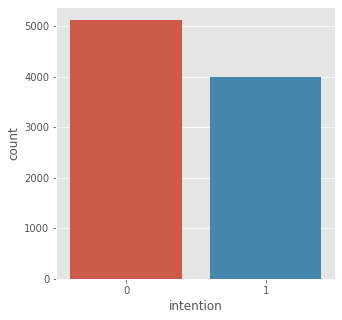

In [ ]:
figure = plt.figure(figsize=(5,5))
figure.set_facecolor("white")
sns.countplot(x='intention', data=df)

### **2.1 Data Cleaning**

In [ ]:
# Check if there is at least single data that is null
df.isnull().values.any()

False

In [ ]:
# Check if there is at least single data that is empty
df.empty

False

In [ ]:
duplicate_rows = df[df.duplicated(['tweet'])]
len(duplicate_rows)

334

In [ ]:
df = df.drop_duplicates()
df

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


Note: There are no null and empty values in the dataset. And duplicates are removed, thus, we can proceed with the next step.

## **3. Data Preprocessing**
In this section, the raw data from the dataset will undergo:
1. Lower case
2. Removing stop words
3. Filter English language

In [ ]:
# Change column order
twitter_data = df.reindex(columns = ['intention', 'tweet'])
twitter_data

,intention,tweet
0,1,my life is meaningless i just want to end my l...
1,1,muttering i wanna die to myself daily for a fe...
2,1,work slave i really feel like my only purpose ...
3,1,i did something on the 2 of october i overdose...
4,1,i feel like no one cares i just want to die ma...
...,...,...
9114,1,have you ever laid on your bed at night and cr...
9115,1,the fault the blame the pain s still there i m...
9116,1,stop asking me to trust you when i m still cou...
9117,1,i never know how to handle sadness crying make...


In [ ]:
# Convert texts to lower case
twitter_data['lowercase_tweet'] = twitter_data['tweet'].apply(lambda x: x.lower())

# Tokenize
tokenizer = RegexpTokenizer(r'\w+')
tokens = twitter_data.apply(lambda row: tokenizer.tokenize(row['lowercase_tweet']), axis=1) 


# Remove less frequent words
freq = pd.Series(' '.join(twitter_data['lowercase_tweet']).split()).value_counts()[-10:]                       
freq = list(freq.index)
filtered1 = twitter_data['lowercase_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Remove stop word
stop_list = stopwords.words('english')
filtered_tokens = tokens.apply(lambda x: [item for item in x if item not in stop_list])   

filtered_tokens = filtered_tokens.astype('str')
clean_str = filtered_tokens.str.findall('\w{3,}').str.join(' ')
#clean_str

In [ ]:
english_words = set([x.lower() for x in nltk.corpus.words.words()])
#english_words

# Remove nonenglish words
clean_str = clean_str.apply(lambda x: " ".join(x for x in x.split() if x in english_words))

# Get root words (to normalize/simplify? the words)
twitter_data['cleaned_tweets'] = clean_str.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


# Assign tweet_id
email_id = range(0, len(twitter_data.index))
twitter_data['tweet_id'] = email_id

# Shift column 'tweet_id' to first position
first_col = twitter_data.pop('tweet_id')
twitter_data.insert(0, 'tweet_id', first_col)

lowercase = twitter_data.pop('lowercase_tweet')

twitter_data

,tweet_id,intention,tweet,cleaned_tweets
0,0,1,my life is meaningless i just want to end my l...,life meaningless want end life badly life comp...
1,1,1,muttering i wanna die to myself daily for a fe...,muttering die daily feel worthless cant live h...
2,2,1,work slave i really feel like my only purpose ...,work slave really feel like purpose life make ...
3,3,1,i did something on the 2 of october i overdose...,something october felt alone horrible hospital...
4,4,1,i feel like no one cares i just want to die ma...,feel like one want die maybe feel le lonely
...,...,...,...,...
9114,8781,1,have you ever laid on your bed at night and cr...,ever laid bed night cried good enough felt wor...
9115,8782,1,the fault the blame the pain s still there i m...,fault blame pain still alone inside broken hom...
9116,8783,1,stop asking me to trust you when i m still cou...,stop trust still water last time let drown
9117,8784,1,i never know how to handle sadness crying make...,never know handle sadness cry feel stupid


In [ ]:
# 1 (suicidal) and 0 (non-sucidal)
# Count the number of 0 or 1
twitter_data['intention'].value_counts()

0    4828
1    3958
Name: intention, dtype: int64

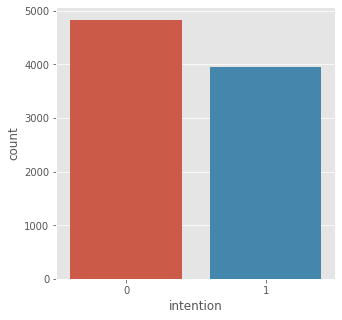

In [ ]:
figure = plt.figure(figsize=(5,5))
figure.set_facecolor("white")
sns.countplot(x='intention', data=twitter_data)

Text(0.5, 1.0, 'Distribution of Intention')

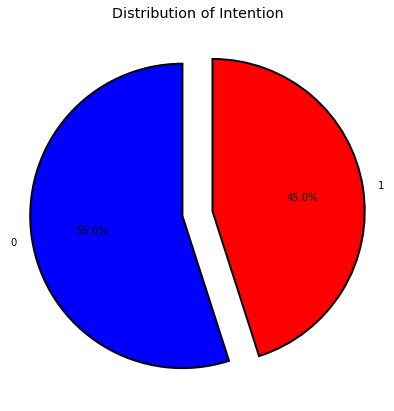

In [ ]:
# Pie Chart for Number of Intentions (0 or 1)
fig = plt.figure(figsize=(7,7))
fig.set_facecolor("white")
colors = ('blue', 'red')
wp = {'linewidth': 2, 'edgecolor':"black"}
tags = twitter_data['intention'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=False, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of Intention")

Only 45% of the data was classified as "1 (suicidal)." Whereas, 55% are non-suicidal.

In [ ]:
# Separate tweets by intentions
# 1 (suicidal) and 0 (non-sucidal)

non_suicidal_tweets = twitter_data[twitter_data.intention == 0]
non_suicidal_tweets

,tweet_id,intention,tweet,cleaned_tweets
3325,3325,0,i wish i got to watch it with you i miss you ...,wish got watch miss premiere
3326,3326,0,i want to go to promote gear and groove but u...,want promote gear groove ride may going one ma...
3327,3327,0,oh manwas ironing fave top to wear to a meetin...,top wear meeting burnt
3328,3328,0,sadly though i ve never gotten to experience t...,sadly though never gotten experience post coit...
3329,3329,0,wonders why someone that u like so much can ma...,someone like much make unhappy split depressed
...,...,...,...,...
9103,8770,0,if you want you can always talk to me,want always talk
9104,8771,0,people don t die from suicide they die from sa...,people die suicide die sadness anonymous
9106,8773,0,she finally let go of her fake smile and tears...,finally let fake smile slowly rolled face whis...
9108,8775,0,wil could ever love the girl with scars,could ever love girl


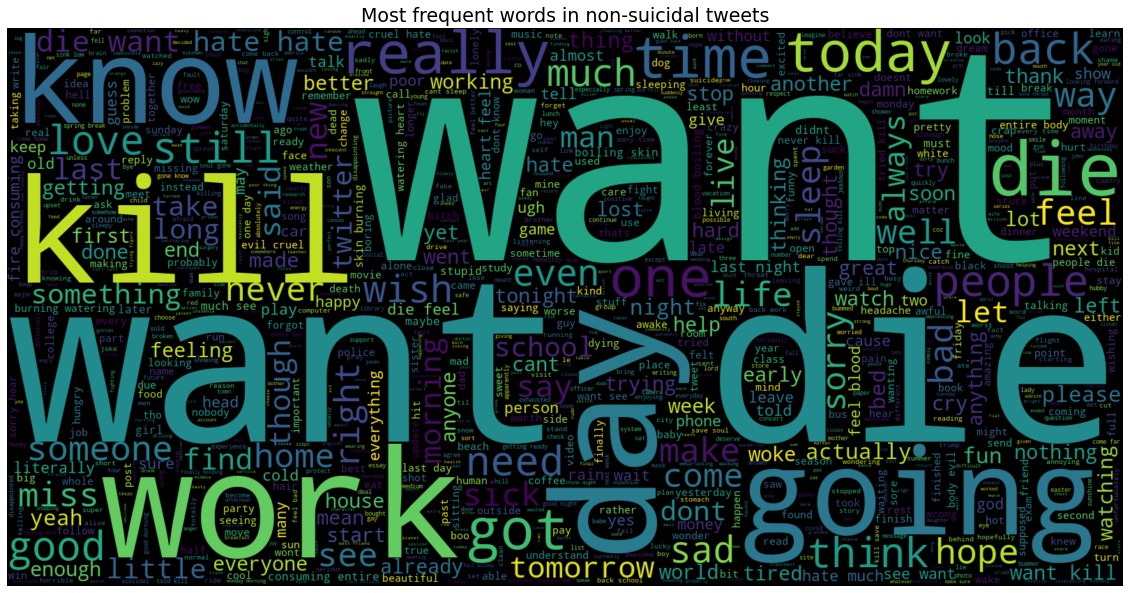

In [ ]:
# Word Cloud for non-suicidal tweets
# 1 (suicidal) and 0 (non-sucidal)
text_0 = ' '.join([word for word in non_suicidal_tweets['cleaned_tweets']])
plt.figure(figsize=(20,15), facecolor="None")
wordcloud_0 = WordCloud(max_words=1000, width=1600, height=800).generate(text_0)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non-suicidal tweets', fontsize=19)
plt.show()

In [ ]:
# Separate tweets by intentions
# 1 (suicidal) and 0 (non-sucidal)

suicidal_tweets = twitter_data[twitter_data.intention == 1]
suicidal_tweets

,tweet_id,intention,tweet,cleaned_tweets
0,0,1,my life is meaningless i just want to end my l...,life meaningless want end life badly life comp...
1,1,1,muttering i wanna die to myself daily for a fe...,muttering die daily feel worthless cant live h...
2,2,1,work slave i really feel like my only purpose ...,work slave really feel like purpose life make ...
3,3,1,i did something on the 2 of october i overdose...,something october felt alone horrible hospital...
4,4,1,i feel like no one cares i just want to die ma...,feel like one want die maybe feel le lonely
...,...,...,...,...
9114,8781,1,have you ever laid on your bed at night and cr...,ever laid bed night cried good enough felt wor...
9115,8782,1,the fault the blame the pain s still there i m...,fault blame pain still alone inside broken hom...
9116,8783,1,stop asking me to trust you when i m still cou...,stop trust still water last time let drown
9117,8784,1,i never know how to handle sadness crying make...,never know handle sadness cry feel stupid


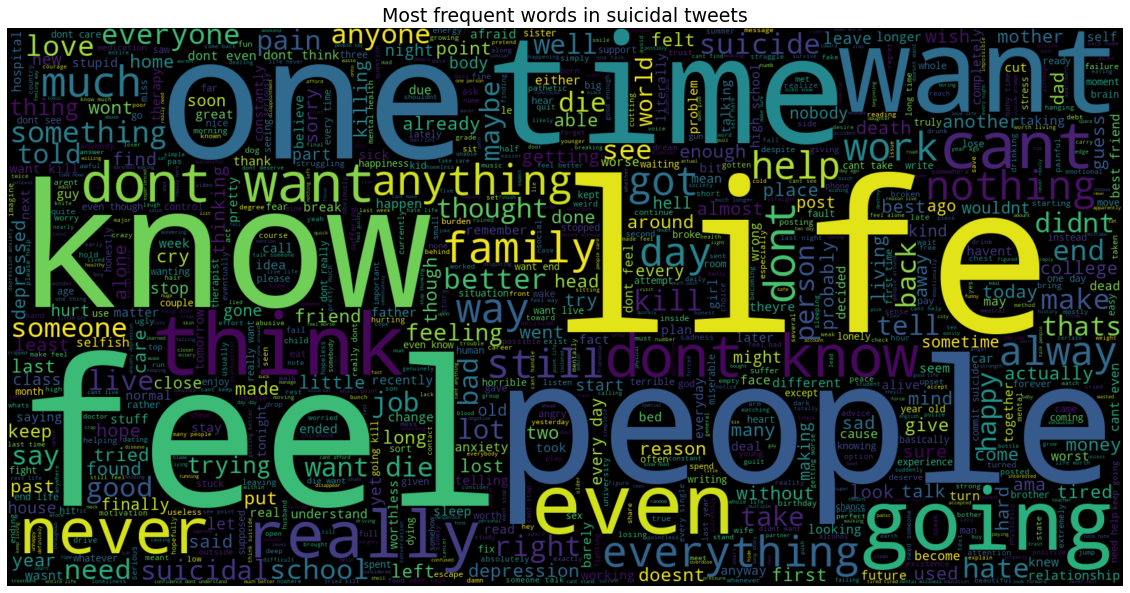

In [ ]:
# Word Cloud for suicidal tweets
# 1 (suicidal) and 0 (non-sucidal)
text_1 = ' '.join([word for word in suicidal_tweets['cleaned_tweets']])
plt.figure(figsize=(20,15), facecolor="None")
wordcloud_1 = WordCloud(max_words=1000, width=1600, height=800).generate(text_1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in suicidal tweets', fontsize=19)
plt.show()

### **3.1 Get Top 10 frequent words in non-suicidal tweets**

In [ ]:
top_N = 10

txt = non_suicidal_tweets['cleaned_tweets'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

print('All frequencies:\n')
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)

All frequencies:
   Word  Frequency
0  want        913
1   die        687
2  like        420
3  kill        378
4   get        316
5   day        315
6  work        300
7  hate        265
8  know        263
9  feel        246


### **3.2 Get Top 10 frequent words in suicidal tweets**

In [ ]:
txt1 = suicidal_tweets['cleaned_tweets'].str.cat(sep=' ')
words1 = nltk.tokenize.word_tokenize(txt1)
word_dist1 = nltk.FreqDist(words1)

print('All frequencies:\n')
rslt1 = pd.DataFrame(word_dist1.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt1)

All frequencies:

   Word  Frequency
0  dont       4321
1  want       3815
2  like       3288
3  feel       3055
4  life       3029
5  know       2863
6  cant       2273
7   get       2263
8  time       2197
9  even       1984


## **4. Split Data**
According to Roshan Joseph (2022), the commonly used ratio is 80:20, which means 80% of the data is for training and 20% for testing. Other ratios such as 70:30, 60:40, and even 50:50 are also used in practice. Hence, this study will use the 80:20 for training and testing, respectively.

Joseph, V. Roshan. (2022). Optimal Ratio for Data Splitting. ResearchGate. https://www.researchgate.net/publication/358423958_Optimal_Ratio_for_Data_Splitting

In [ ]:
X = twitter_data['cleaned_tweets']
Y = twitter_data['intention']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)  

In [ ]:
print("Size of x_train = ", x_train.shape)
print("Size of y_train = ", y_train.shape)
print("Size of x_test = ", x_test.shape)
print("Size of y_train = ", y_test.shape)

Size of x_train =  (7028,)
Size of y_train =  (7028,)
Size of x_test =  (1758,)
Size of y_train =  (1758,)


## **5. Feature Extraction using CountVectorizer and TFIDF**

In [ ]:
# Convert the collection of tweets to a matrix of token counts

count_vector = CountVectorizer()
tfidf_transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

x_train_count = count_vector.fit_transform(x_train)
X_train = tfidf_transformer.fit_transform(x_train_count)

x_test_count = count_vector.transform(x_test)
X_test = tfidf_transformer.fit_transform(x_test_count)

# Rather fit_transform only the train set, and then just transform the test set
# This is done because we would require the vocabulary and
# the document frequencies of the train set to be learnt and
# be transformed into a terms-document matrix, and when it comes to test set,
# just the learnt document frequencies is to used to only transform the test set into a terms-document matrix.
# Source: https://stackoverflow.com/questions/71456258/x-has-4211-features-but-gaussiannb-is-expecting-8687-features-as-input

In [ ]:
print(X_train.shape, y_train.shape)

(7028, 8882) (7028,)


In [ ]:
print(X_test.shape, y_test.shape)

(1758, 8882) (1758,)


## **6. Machine Learning Model**

### **6.1 GaussianNB and its Performance Metrics**

Number of mislabeled points out of a total 1758 points : 374

Accuracy Score:  0.7872582480091013
Accuracy Score (%): 78.73%

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80       938
           1       0.78      0.76      0.77       820

    accuracy                           0.79      1758
   macro avg       0.79      0.79      0.79      1758
weighted avg       0.79      0.79      0.79      1758



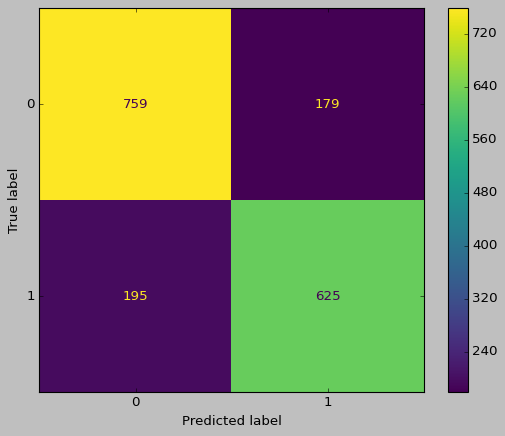

In [ ]:
model_gaussianNB= GaussianNB()                                 
model_gaussianNB.fit(X_train.todense(),y_train)
y_gaussianNB_predict = model_gaussianNB.predict(X_test.todense())

print("Number of mislabeled points out of a total %d points : %d\n"
      % (X_test.shape[0], (y_test != y_gaussianNB_predict).sum()))

# Get Accuracy score
accuracy_gaussianNB = accuracy_score(y_test, y_gaussianNB_predict)
print("Accuracy Score: ", accuracy_gaussianNB)
print("Accuracy Score (%): {:.2f}%\n".format(accuracy_gaussianNB*100))

# Get Classification Metrics report
print("Classification Report:\n", classification_report(y_test, y_gaussianNB_predict))

# Confusion Matrix
style.use('classic')
confusion_mx = confusion_matrix(y_test, y_gaussianNB_predict, labels=model_gaussianNB.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_mx, display_labels=model_gaussianNB.classes_)
print(display.plot())


### **6.2 BernoulliNB and its Performance Metrics**

Number of mislabeled points out of a total 1758 points : 252

Accuracy Score:  0.856655290102389
Accuracy Score (%): 85.67%

Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       938
           1       1.00      0.70      0.82       820

    accuracy                           0.86      1758
   macro avg       0.89      0.85      0.85      1758
weighted avg       0.89      0.86      0.85      1758



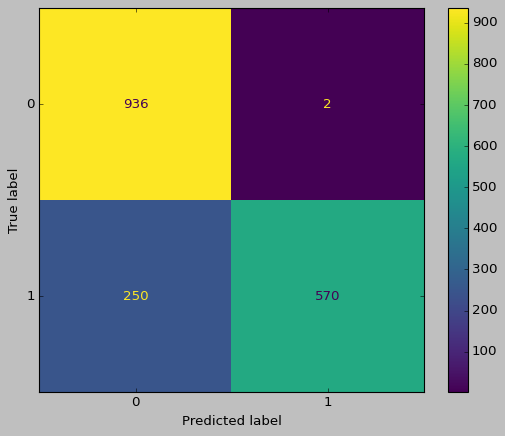

In [ ]:
model_bernoulliNB = BernoulliNB(fit_prior=True)
model_bernoulliNB.fit(X_train,y_train)
y_bernoulliNB_predict = model_bernoulliNB.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d\n"
      % (X_test.shape[0], (y_test != y_bernoulliNB_predict).sum()))

# Get Accuracy score
accuracy_bernoulliNB = accuracy_score(y_test, y_bernoulliNB_predict)
print("Accuracy Score: ", accuracy_bernoulliNB)
print("Accuracy Score (%): {:.2f}%\n".format(accuracy_bernoulliNB*100))

# Get Classification Metrics report
print("Classification Report:\n", classification_report(y_test, y_bernoulliNB_predict))

# Confusion Matrix
style.use('classic')
confusion_mx1 = confusion_matrix(y_test, y_bernoulliNB_predict, labels=model_bernoulliNB.classes_)
display1 = ConfusionMatrixDisplay(confusion_matrix=confusion_mx1, display_labels=model_bernoulliNB.classes_)
print(display1.plot())


### **6.3 Random Forest and its Performance Metrics**

In [ ]:
# Test for n_estimator value
params_to_test = {'n_estimators':[100, 200, 300, 400, 500]}

In [ ]:
# Find the optimal value of n_estimator
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid=params_to_test, cv=10, scoring='f1_macro', n_jobs=4)

grid_search.fit(X_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))

best_params = grid_search.best_params_ 
print("Best n_estimator parameter: ", best_params)
#best_params = 400

Best Cross validation score: 0.90
Best n_estimator parameter:  {'n_estimators': 400}


Number of mislabeled points out of a total 1758 points : 168

Accuracy Score:  0.9044368600682594
Accuracy Score (%): 90.44%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       938
           1       0.96      0.83      0.89       820

    accuracy                           0.90      1758
   macro avg       0.91      0.90      0.90      1758
weighted avg       0.91      0.90      0.90      1758



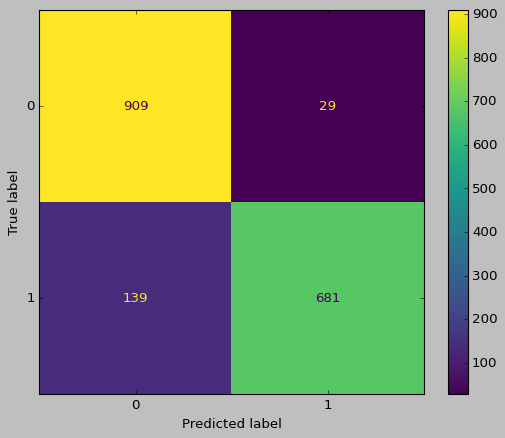

In [ ]:
n_est = best_params.get('n_estimators')
#n_est = 400
model_randomforest = RandomForestClassifier(n_estimators=n_est, random_state=0)
model_randomforest.fit(X_train, y_train)
y_randomforest_predict = model_randomforest.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d\n"
      % (X_test.shape[0], (y_test != y_randomforest_predict).sum()))

# Get Accuracy score
accuracy_randomforest = accuracy_score(y_test, y_randomforest_predict)
print("Accuracy Score: ", accuracy_randomforest)
print("Accuracy Score (%): {:.2f}%\n".format(accuracy_randomforest*100))

# Get Classification Metrics report
print("Classification Report:\n", classification_report(y_test, y_randomforest_predict))

# Confusion Matrix
style.use('classic')
confusion_mx2 = confusion_matrix(y_test, y_randomforest_predict, labels=model_randomforest.classes_)
display2 = ConfusionMatrixDisplay(confusion_matrix=confusion_mx2, display_labels=model_randomforest.classes_)
print(display2.plot())


Number of mislabeled points out of a total 1758 points : 169

Accuracy Score:  0.90386803185438
Accuracy Score (%): 90.39%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.92       938
           1       0.96      0.82      0.89       820

    accuracy                           0.90      1758
   macro avg       0.91      0.90      0.90      1758
weighted avg       0.91      0.90      0.90      1758



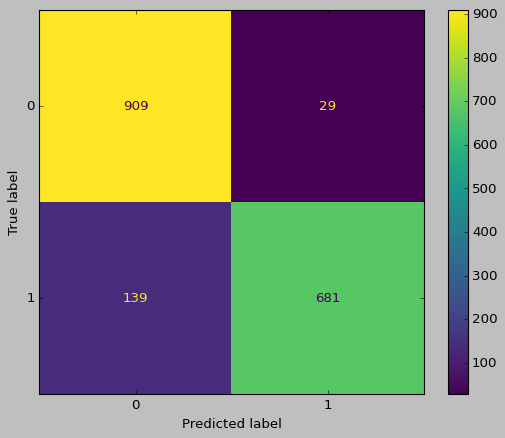

In [ ]:
# n_est = 100
n_est = 100

model_randomforest1 = RandomForestClassifier(n_estimators=n_est, random_state=0)
model_randomforest1.fit(X_train, y_train)
y_randomforest_predict1 = model_randomforest1.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d\n"
      % (X_test.shape[0], (y_test != y_randomforest_predict1).sum()))

# Get Accuracy score
accuracy_randomforest1 = accuracy_score(y_test, y_randomforest_predict1)
print("Accuracy Score: ", accuracy_randomforest1)
print("Accuracy Score (%): {:.2f}%\n".format(accuracy_randomforest1*100))

# Get Classification Metrics report
print("Classification Report:\n", classification_report(y_test, y_randomforest_predict1))

# Confusion Matrix
style.use('classic')
confusion_mx3 = confusion_matrix(y_test, y_randomforest_predict, labels=model_randomforest1.classes_)
display3 = ConfusionMatrixDisplay(confusion_matrix=confusion_mx2, display_labels=model_randomforest1.classes_)
print(display3.plot())


### **6.4 Logistic Regression and its Performance Metrics**

Number of mislabeled points out of a total 1758 points : 181

Accuracy Score:  0.897042093287827
Accuracy Score (%): 89.70%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91       938
           1       0.93      0.85      0.88       820

    accuracy                           0.90      1758
   macro avg       0.90      0.89      0.90      1758
weighted avg       0.90      0.90      0.90      1758



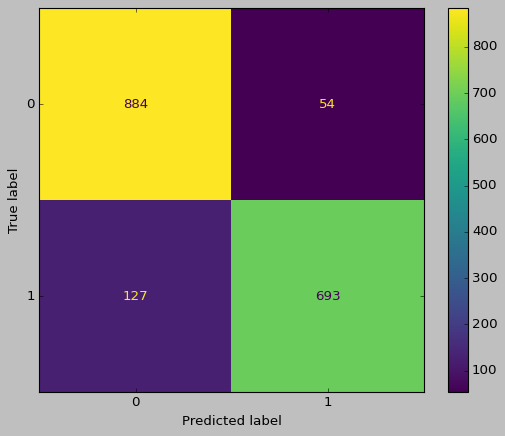

In [ ]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)
y_logreg_predict = model_logreg.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d\n"
      % (X_test.shape[0], (y_test != y_logreg_predict).sum()))

# Get Accuracy score
accuracy_logreg = accuracy_score(y_test, y_logreg_predict)
print("Accuracy Score: ", accuracy_logreg)
print("Accuracy Score (%): {:.2f}%\n".format(accuracy_logreg*100))

# Get Classification Metrics report
print("Classification Report:\n", classification_report(y_test, y_logreg_predict))

# Confusion Matrix
style.use('classic')
confusion_mx4 = confusion_matrix(y_test, y_logreg_predict, labels=model_logreg.classes_)
display4 = ConfusionMatrixDisplay(confusion_matrix=confusion_mx4, display_labels=model_logreg.classes_)
print(display4.plot())


In [ ]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(model_logreg, param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.90
Best parameters:  {'C': 10, 'solver': 'liblinear'}


In [ ]:
y_pred = grid.predict(X_test)
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Test accuracy: 89.59%
[[868  70]
 [113 707]]


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       938
           1       0.91      0.86      0.89       820

    accuracy                           0.90      1758
   macro avg       0.90      0.89      0.90      1758
weighted avg       0.90      0.90      0.90      1758



## **7. Summary**
Make a comparison table for all the machine learning models used to detect/predict the suicide ideation tweets.

In [ ]:
comparison_table = pd.DataFrame({'GaussianNB': [accuracy_gaussianNB*100,f1_score(y_test,y_gaussianNB_predict,average='macro')*100,recall_score(y_test,y_gaussianNB_predict)*100,precision_score(y_test,y_gaussianNB_predict)*100],
                                'BernoulliNB': [accuracy_bernoulliNB*100,f1_score(y_test,y_bernoulliNB_predict,average='macro')*100,recall_score(y_test,y_bernoulliNB_predict)*100,precision_score(y_test,y_bernoulliNB_predict)*100],
                                'RandomForest(n_est=400)': [accuracy_randomforest*100,f1_score(y_test,y_randomforest_predict,average='macro')*100,recall_score(y_test,y_randomforest_predict)*100,precision_score(y_test,y_randomforest_predict)*100],
                                'RandomForest(n_est=100)': [accuracy_randomforest1*100,f1_score(y_test,y_randomforest_predict1,average='macro')*100,recall_score(y_test,y_randomforest_predict1)*100,precision_score(y_test,y_randomforest_predict1)*100],
                                'LogesticRegression': [accuracy_logreg*100,f1_score(y_test,y_bernoulliNB_predict,average='macro')*100,recall_score(y_test,y_bernoulliNB_predict)*100,precision_score(y_test,y_bernoulliNB_predict)*100]})

comparison_table.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
comparison_table.head()

,GaussianNB,BernoulliNB,RandomForest(n_est=400),RandomForest(n_est=100),LogesticRegression
Accuracy,77.302632,86.567982,91.557018,91.063596,89.967105
F1_score,77.020801,85.701556,91.331815,90.823565,85.701556
Recall,75.031056,70.186335,85.465839,84.844720,70.186335
Precision,73.929009,99.122807,94.896552,94.337017,99.122807


# END